# HTPC Graph-Based Full Model
A high-level implementation of a **Hierarchical Temporal Predictive Coding (HTPC)** cortical model using a graph-based structure.

- Each **node** represents a cortical column (e.g., minicolumn or macrocolumn)
- **Edges** represent feedforward, feedback, and lateral predictive connections

In [3]:
# Imports
import networkx as nx
import numpy as np
from collections import defaultdict

## HTMNeuron Class
Defines a simplified neuron with prediction and activation tracking.

In [4]:
class HTMNeuron:
    def __init__(self, id, layer, column_id):
        self.id = id
        self.layer = layer
        self.column_id = column_id
        self.active = False
        self.predictive = False
        self.activation_history = []
        self.incoming_synapses = defaultdict(float)  # neuron_id -> permanence
        self.outgoing_synapses = defaultdict(float)

    def compute_prediction(self, active_neurons):
        pred_input = sum(self.incoming_synapses[n.id] for n in active_neurons if n.id in self.incoming_synapses)
        self.predictive = pred_input > 0.5  # Threshold can be tuned
        return self.predictive

    def activate(self):
        self.active = True
        self.activation_history.append(1)

    def deactivate(self):
        self.active = False
        self.activation_history.append(0)

## CorticalColumn Class
Groups a set of neurons into a single cortical column.

In [5]:
class CorticalColumn:
    def __init__(self, id, layer, n_neurons=4):
        self.id = id
        self.layer = layer
        self.neurons = [HTMNeuron(f"{id}_{i}", layer, id) for i in range(n_neurons)]

    def get_active_neurons(self):
        return [n for n in self.neurons if n.active]

    def get_predictive_neurons(self):
        return [n for n in self.neurons if n.predictive]

## HTPCGraphModel Class
The full graph structure, with methods for adding columns, connecting them, and propagating activity.

In [6]:
class HTPCGraphModel:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.columns = {}  # id -> CorticalColumn

    def add_column(self, id, layer):
        column = CorticalColumn(id, layer)
        self.columns[id] = column
        self.graph.add_node(id, column=column)

    def connect_columns(self, src_id, tgt_id, weight=1.0, conn_type="feedforward"):
        self.graph.add_edge(src_id, tgt_id, weight=weight, type=conn_type)

    def propagate_activity(self):
        for column in self.columns.values():
            for neuron in column.neurons:
                active_sources = self.get_active_neurons_from_inputs(neuron)
                neuron.compute_prediction(active_sources)

        for column in self.columns.values():
            for neuron in column.neurons:
                if neuron.predictive:
                    neuron.activate()
                else:
                    neuron.deactivate()

    def get_active_neurons_from_inputs(self, neuron):
        inputs = []
        for src_id, _, data in self.graph.in_edges(neuron.column_id, data=True):
            if data['type'] in ("feedforward", "lateral"):
                src_column = self.columns[src_id]
                inputs.extend(src_column.get_active_neurons())
        return inputs

    def reset_activations(self):
        for column in self.columns.values():
            for neuron in column.neurons:
                neuron.active = False
                neuron.predictive = False

## Run Example
Manually activate a neuron in V1 and propagate activity to V2.

Neuron V2_0: Active=False, Predictive=False
Neuron V2_1: Active=False, Predictive=False
Neuron V2_2: Active=False, Predictive=False
Neuron V2_3: Active=False, Predictive=False


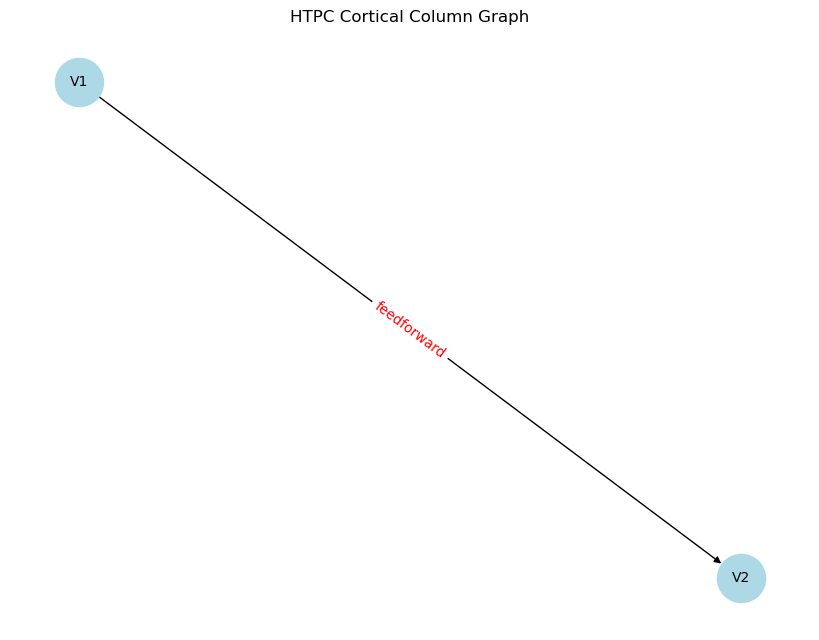

In [8]:
# Example usage
model = HTPCGraphModel()
model.add_column("V1", layer="L4")
model.add_column("V2", layer="L4")
model.connect_columns("V1", "V2", weight=1.0, conn_type="feedforward")

# Activate a neuron in V1
v1_column = model.columns["V1"]
v1_column.neurons[0].activate()

# Propagate activity
model.propagate_activity()

# Check V2 output
v2_column = model.columns["V2"]
for neuron in v2_column.neurons:
    print(f"Neuron {neuron.id}: Active={neuron.active}, Predictive={neuron.predictive}")

import matplotlib.pyplot as plt

def visualize_htpc_graph(model):
    pos = nx.spring_layout(model.graph, seed=42)  # or use shell_layout/circular_layout
    edge_labels = nx.get_edge_attributes(model.graph, 'type')

    plt.figure(figsize=(8, 6))
    nx.draw(model.graph, pos, with_labels=True, node_color='lightblue', node_size=1200, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(model.graph, pos, edge_labels=edge_labels, font_color='red')
    plt.title("HTPC Cortical Column Graph")
    plt.axis('off')
    plt.show()

# Call the function
visualize_htpc_graph(model)
